<a href="https://colab.research.google.com/github/devpathak0212/Oil-Spill-Detection/blob/main/DeepLearningModels/PSPNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing the datasets from kaggle**

In [ ]:
!pip install kaggle --upgrade

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nabilsherif/oil-spill

Dataset URL: https://www.kaggle.com/datasets/nabilsherif/oil-spill
License(s): unknown


In [ ]:
!unzip '/content/oil-spill.zip'

Archive:  /content/oil-spill.zip
  inflating: oil-spill/test/images/img_0001.jpg  
  inflating: oil-spill/test/images/img_0002.jpg  
  inflating: oil-spill/test/images/img_0003.jpg  
  inflating: oil-spill/test/images/img_0004.jpg  
  inflating: oil-spill/test/images/img_0005.jpg  
  inflating: oil-spill/test/images/img_0006.jpg  
  inflating: oil-spill/test/images/img_0007.jpg  
  inflating: oil-spill/test/images/img_0008.jpg  
  inflating: oil-spill/test/images/img_0009.jpg  
  inflating: oil-spill/test/images/img_0010.jpg  
  inflating: oil-spill/test/images/img_0011.jpg  
  inflating: oil-spill/test/images/img_0012.jpg  
  inflating: oil-spill/test/images/img_0013.jpg  
  inflating: oil-spill/test/images/img_0014.jpg  
  inflating: oil-spill/test/images/img_0015.jpg  
  inflating: oil-spill/test/images/img_0016.jpg  
  inflating: oil-spill/test/images/img_0017.jpg  
  inflating: oil-spill/test/images/img_0018.jpg  
  inflating: oil-spill/test/images/img_0019.jpg  
  inflating: oil-

# **Importing the Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors

import cv2
import PIL.Image as Image
from PIL import ImageOps
import os
import glob as glob
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks
from keras.models import Sequential, Model
from keras.utils import load_img, normalize
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import Concatenate, concatenate, BatchNormalization, Dropout, Lambda, Activation
from keras.applications import ResNet50
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator


from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import random
from IPython.display import Image, display

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support,accuracy_score

from keras.models import Model
from keras import backend as K

# **Constants and file paths**

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CLASSES = 5
IMG_CHANNELS = 3

IMG_PATH = '/content/oil-spill/train/images'
LABELS_PATH = '/content/oil-spill/train/labels'

IMG_PATH_TEST = '/content/oil-spill/test/images'
LABELS_PATH_TEST = '/content/oil-spill/test/labels'

# **List of Images**

In [ ]:
# Get a list of all image filenames in the directory
IMG_IDS = sorted(os.listdir(IMG_PATH))
LABELS_IDS = sorted(os.listdir(LABELS_PATH))

IMG_IDS_TEST = sorted(os.listdir(IMG_PATH_TEST))
LABELS_IDS_TEST = sorted(os.listdir(LABELS_PATH_TEST))

# **Visualize Images**

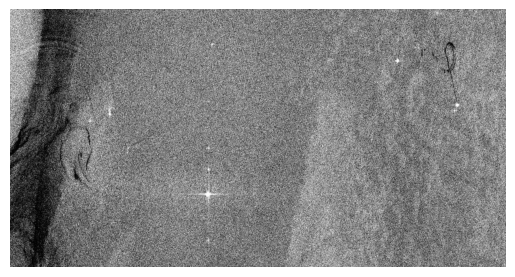

Image:  img_0006.jpg


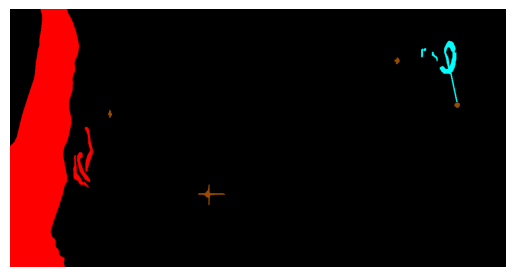

Respective mask:  img_0006.png


In [ ]:
# Choose a random image and mask filename from the list
sample_image = IMG_IDS[5]
sample_mask = LABELS_IDS[5]

# Construct the full image path
image_path = os.path.join(IMG_PATH, sample_image)
mask_path = os.path.join(LABELS_PATH, sample_mask)

# Read and plot the image
img = mpimg.imread(image_path)
mask = mpimg.imread(mask_path)

plt.imshow(img)
plt.axis('off')
plt.savefig('img5.png')
plt.show()

print("Image: ", sample_image)

plt.imshow(mask)
plt.axis('off')
plt.savefig('mask5.png')
plt.show()


print("Respective mask: ", sample_mask)

# Color **Mask**

In [ ]:
COLOR_MAP = [
    [0, 0, 0],
    [0, 255, 255],
    [255, 0, 0],
    [153, 76, 0],
    [0, 153, 0],
]

def process_mask(rgb_mask, colormap):
    output_mask = []

    for i, color in enumerate(colormap):
        cmap = np.all(np.equal(rgb_mask, color), axis=-1)
        output_mask.append(cmap)

    output_mask = np.stack(output_mask, axis=-1)
    return output_mask

In [ ]:
train_images = []
train_masks = []

test_images = []
test_masks = []

# **Loading Training Images**

In [ ]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS, LABELS_IDS),total = len(IMG_IDS)):
    image_path = os.path.join(IMG_PATH, image_filename)
    mask_path = os.path.join(LABELS_PATH, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))

    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    train_images.append(image)
    train_masks.append(grayscale_mask)

# Convert the lists to arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)

100%|██████████| 1002/1002 [00:18<00:00, 55.39it/s]


# **Loading Testing Images**

In [ ]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS_TEST, LABELS_IDS_TEST),total = len(IMG_IDS_TEST)):
    image_path = os.path.join(IMG_PATH_TEST, image_filename)
    mask_path = os.path.join(LABELS_PATH_TEST, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))

    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    test_images.append(image)
    test_masks.append(grayscale_mask)

# Convert the lists to np arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)

100%|██████████| 110/110 [00:01<00:00, 60.44it/s]


In [ ]:
train_masks.shape

(1002, 128, 128, 1)

In [ ]:
test_masks.shape

(110, 128, 128, 1)

In [ ]:
unique_values = np.unique(train_masks)
print("Unique values in train_masks:", unique_values)

Unique values in train_masks: [0 1 2 3 4]


In [ ]:
unique_values = np.unique(test_masks)
print("Unique values in test_masks:", unique_values)

Unique values in test_masks: [0 1 2 3 4]


# **Displaying few Masked Images**

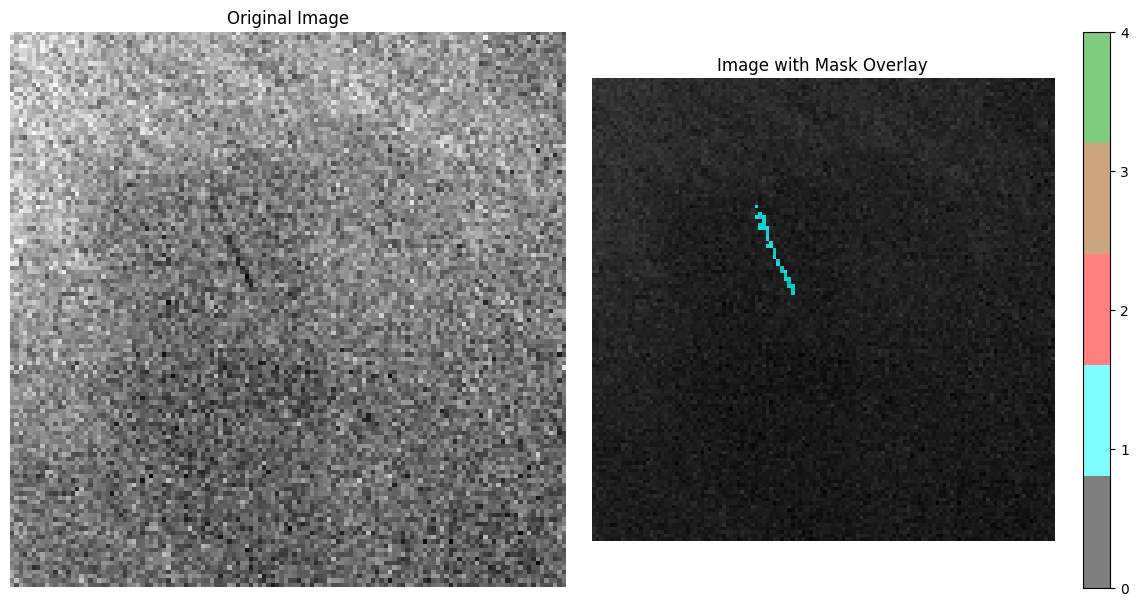

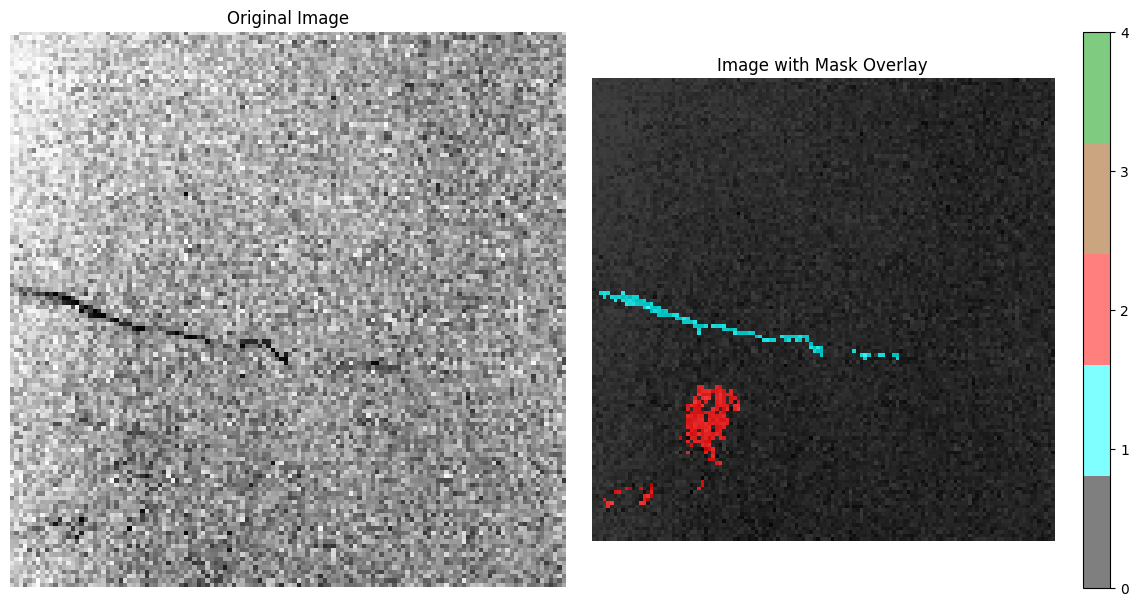

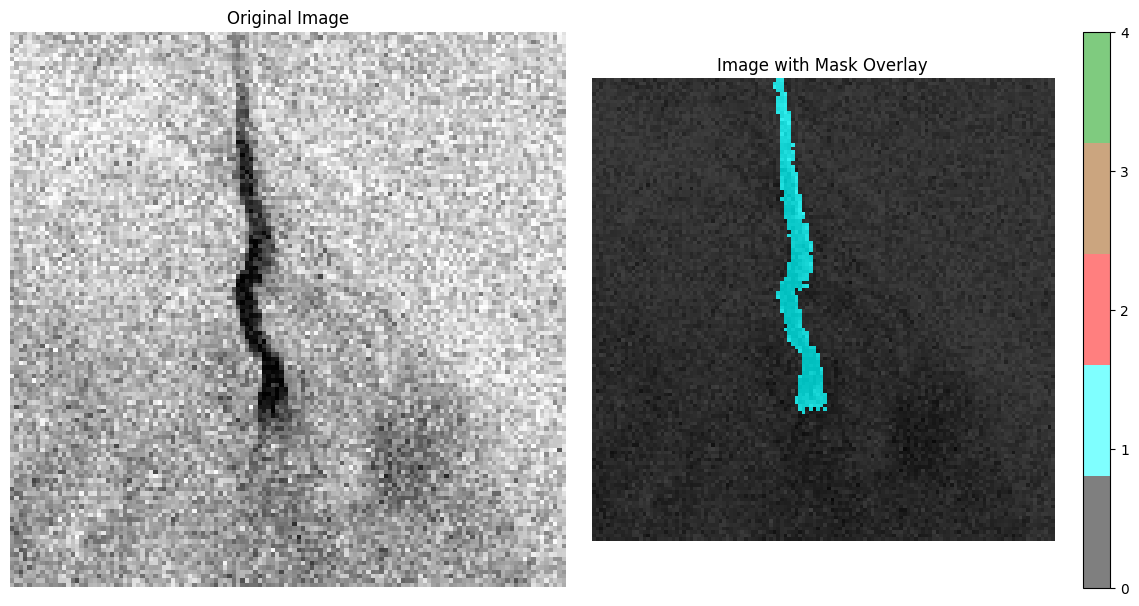

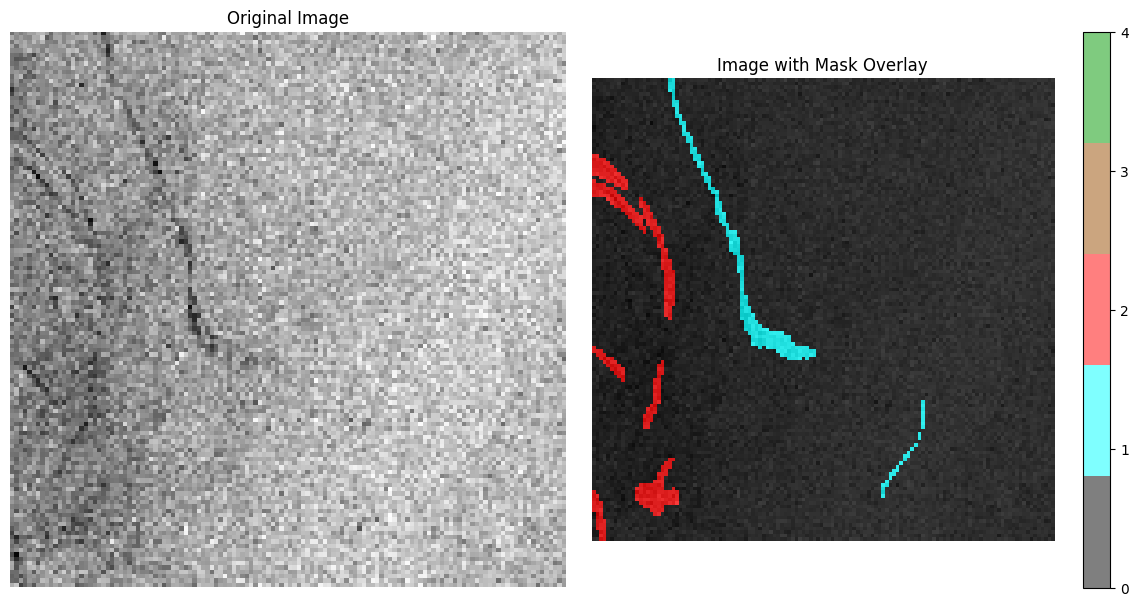

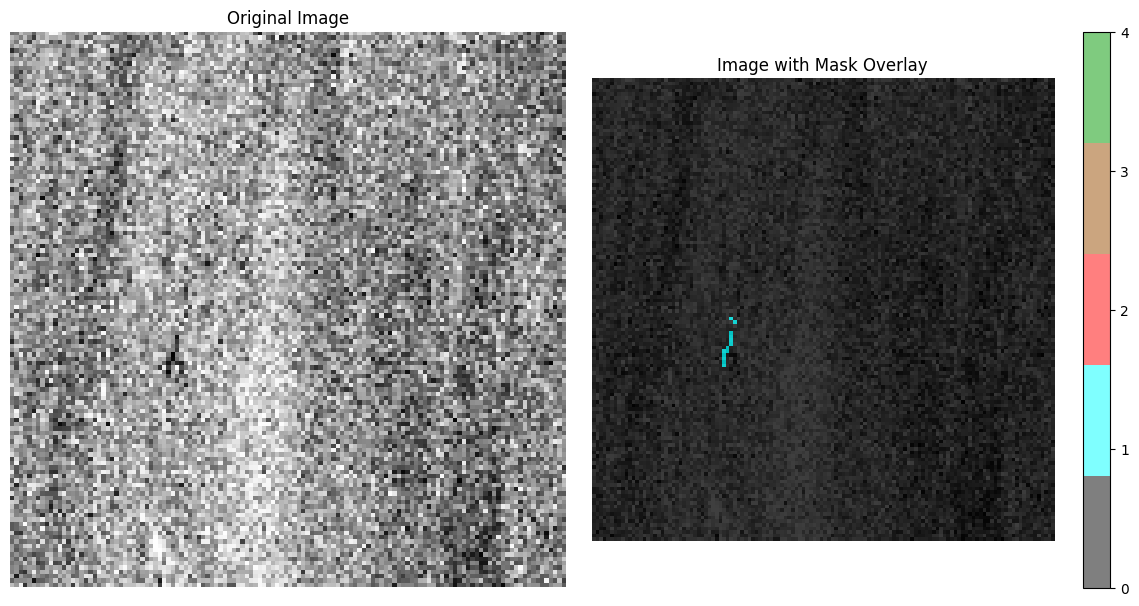

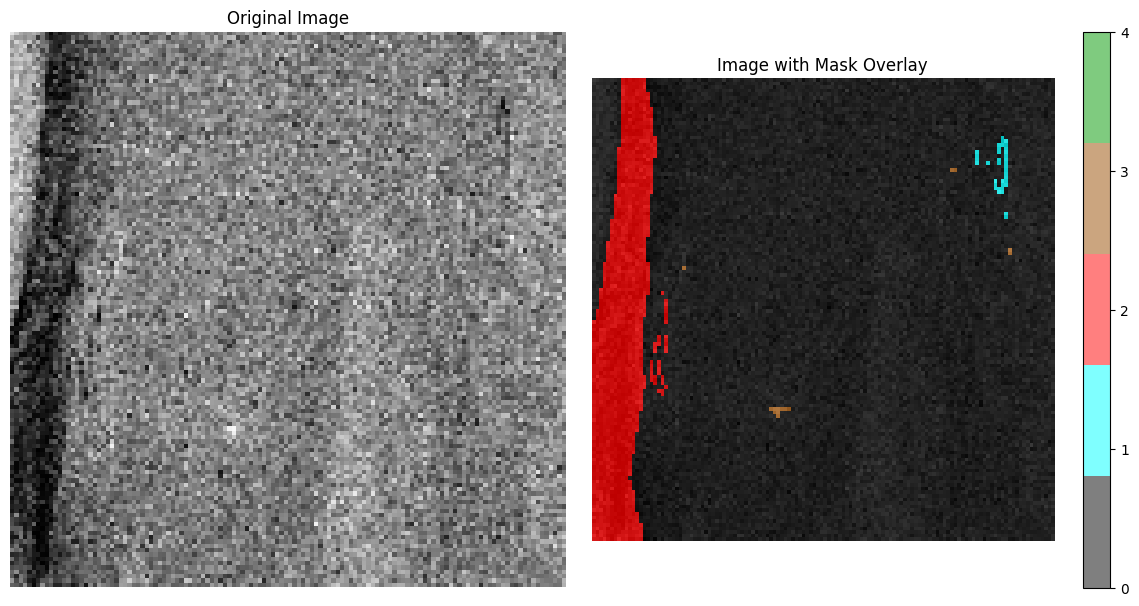

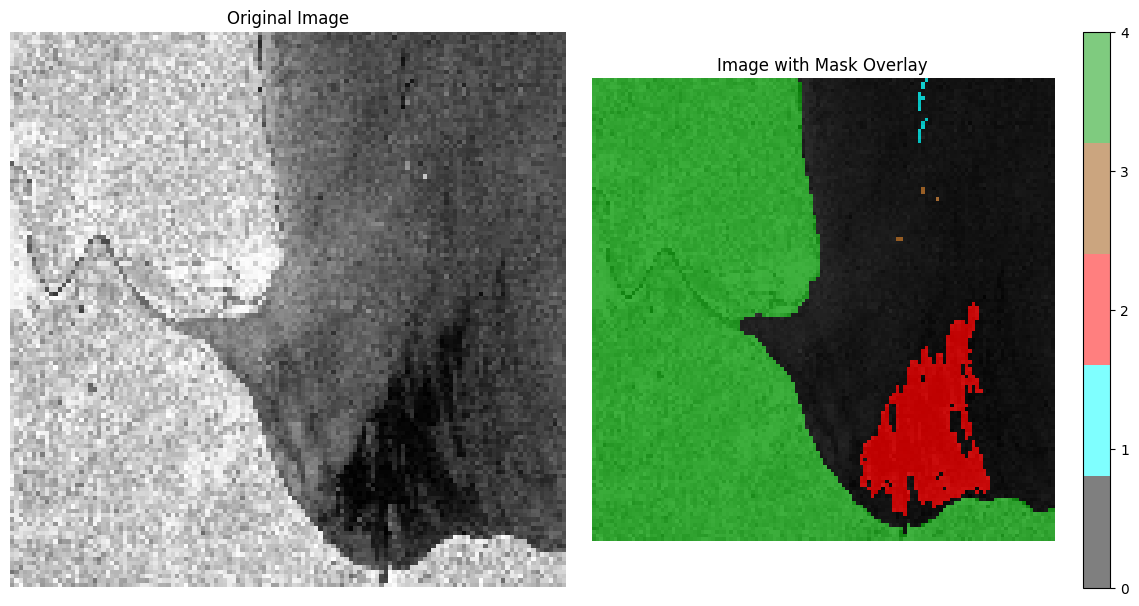

In [ ]:
# Assuming COLOR_MAP and train_images, train_masks are defined as in the original notebook
scaled_color_map = [[c[0] / 255.0, c[1] / 255.0, c[2] / 255.0] for c in COLOR_MAP]
cmap = mcolors.ListedColormap(scaled_color_map)
num_images_to_plot = 7

for i in range(num_images_to_plot):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns of subplots

    # Display the original image on the left subplot
    axes[0].imshow(train_images[i])
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Display the image with mask overlay on the right subplot
    mask_overlay = train_masks[i].squeeze()
    axes[1].imshow(train_images[i])  # Display the original image again as the base
    axes[1].imshow(mask_overlay, cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, alpha=0.5, interpolation='none')  # Overlay mask with transparency
    axes[1].set_title("Image with Mask Overlay")
    axes[1].axis('off')

    plt.colorbar(axes[1].imshow(mask_overlay, cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, alpha=0.5, interpolation='none'), ax = axes[1] ,ticks=range(len(COLOR_MAP))) # Add a colorbar to the overlay plot

    plt.tight_layout() # adjust subplot parameters to give specified padding
    plt.show()

In [ ]:
train_masks = to_categorical(train_masks, num_classes = 5)
test_masks = to_categorical(test_masks, num_classes = 5)

In [ ]:
print(train_images.shape)
print(train_masks.shape)

(1002, 128, 128, 3)
(1002, 128, 128, 5)


In [ ]:
print(test_images.shape)
print(test_masks.shape)

(110, 128, 128, 3)
(110, 128, 128, 5)


In [ ]:
print(np.unique(train_masks))
print(np.unique(test_masks))

[0. 1.]
[0. 1.]


# **Creating Model**

In [ ]:
def PSPNet(input_shape, IMG_CLASSES):
    inputs = Input(input_shape)

    resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

    pyramid_layers = []

    for pool_size in [1, 2, 3, 4]:  # Changed largest pool_size to 4
        pyramid = AveragePooling2D(pool_size=(pool_size, pool_size), padding='same')(resnet.output)  # Added padding='same'
        pyramid = Conv2D(128, (1, 1), activation='relu')(pyramid)
        pyramid = Lambda(lambda x: tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH), method='bilinear'))(pyramid)
        pyramid_layers.append(pyramid)

    merged = Concatenate(axis=-1)(pyramid_layers)
    merged = BatchNormalization()(merged)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(merged)
    x = Dropout(0.5)(x)
    x = Conv2D(IMG_CLASSES, (1, 1), activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
pspnet_model = PSPNet(input_shape, IMG_CLASSES)
pspnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 27,001,221 (103.00 MB)

 Trainable params: 26,947,077 (102.79 MB)

 Non-trainable params: 54,144 (211.50 KB)

In [ ]:
import tensorflow.keras.backend as K  # Import the correct backend

def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)  # Use K.flatten from the correct backend
    y_pred_flatten = K.flatten(y_pred)
    # Cast y_pred_flatten to float32 to match y_true_flatten's type
    y_pred_flatten = tf.cast(y_pred_flatten, dtype=tf.float32)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

In [ ]:
# treating all classes equally in terms of their contribution to the loss.
class_weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [ ]:
!pip install -U -q segmentation-models
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

dice_loss = sm.losses.DiceLoss(class_weights = class_weights)
focal_loss = sm.losses.CategoricalFocalLoss()

total_loss = dice_loss + focal_loss

In [ ]:
data_gen_args = dict(
    rotation_range=20,  # Rotate images by up to 20 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of the height
    shear_range=0.2,  # Apply shear transformations
    zoom_range=0.2,  # Zoom in or out by up to 20%
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels using the nearest neighbor method
)

In [ ]:
# Create image data generators
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [ ]:
def train_generator_fn(image_datagen, mask_datagen, train_images, train_masks, batch_size):
    image_generator = image_datagen.flow(train_images, batch_size=batch_size, seed=42)
    mask_generator = mask_datagen.flow(train_masks, batch_size=batch_size, seed=42)
    while True:
        yield next(image_generator), next(mask_generator)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=10,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',   # Metric to monitor (e.g., validation loss)
    factor=0.1,            # Factor by which the learning rate will be reduced
    patience=5,           # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6           # Lower bound on the learning rate
)

In [ ]:
import tensorflow as tf

tf.keras.backend.clear_session()
# Comment out or remove the mixed precision policy
# tf.keras.mixed_precision.set_global_policy('mixed_float16')  # Enable mixed precision

# Force all tensors to float32 data type
for layer in pspnet_model.layers:
    if hasattr(layer, 'dtype_policy'):
        layer.dtype_policy = tf.keras.mixed_precision.Policy('float32')

pspnet_model.compile(optimizer='adam', loss=total_loss, metrics=["accuracy", jaccard_coef])

In [ ]:
# Call the train_generator_fn to create a generator
batch_size = 8  # Reduced batch size
train_generator = train_generator_fn(image_datagen, mask_datagen, train_images, train_masks, batch_size)

history = pspnet_model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=50,
    validation_data=(test_images, test_masks),
    verbose=1,
    callbacks=[early_stopping, lr_scheduler]  # Add both callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1002, 128, 128, 5) (5 channels).
  warnings.warn(


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 119s 388ms/step - accuracy: 0.7655 - jaccard_coef: 0.5880 - loss: 1.0120 - val_accuracy: 0.9082 - val_jaccard_coef: 0.4204 - val_loss: 0.9804 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 350ms/step - accuracy: 0.8665 - jaccard_coef: 0.6669 - loss: 0.9759 - val_accuracy: 0.0854 - val_jaccard_coef: 0.1277 - val_loss: 1.0684 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 340ms/step - accuracy: 0.8489 - jaccard_coef: 0.6366 - loss: 0.9696 - val_accuracy: 0.9082 - val_jaccard_coef: 0.7990 - val_loss: 0.9974 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 338ms/step - accuracy: 0.8679 - jaccard_coef: 0.6983 - loss: 0.9626 - val_accuracy: 0.9082 - val_jaccard_coef: 0.7927 - val_loss: 0.9976 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 339ms/step - accuracy: 0.8685 - jaccard_coef: 0.6928 - loss: 0.9623 - val_accuracy: 0.9082 - val_jaccard_coef: 0.7460 - val_loss: 0.993

In [ ]:







# Generate a random index within the range of test_images
test_image_number = random.randint(0, len(test_images) - 1)

# Retrieve the test image and its corresponding ground truth
test_image = test_images[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

# Expand dimensions of the test image to match the model input shape
test_image_input = np.expand_dims(test_image, axis=0)

# Get the model's prediction for the test image
prediction = pspnet_model.predict(test_image_input)

# Find the index of the highest predicted value along the channel axis
predicted_image = np.argmax(prediction, axis=3)[0, :, :]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


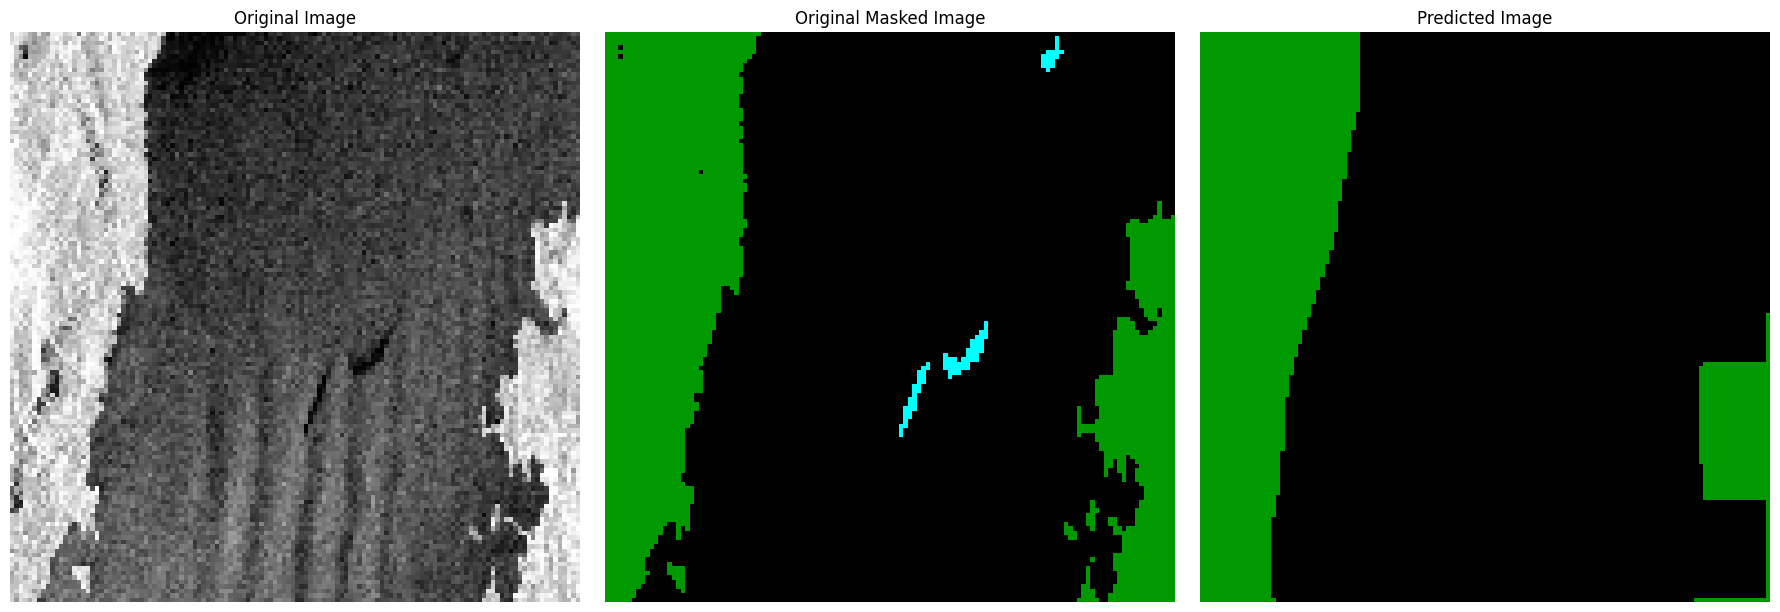

In [ ]:
# Generate a random index within the range of test_images
test_image_number = 71

# Retrieve the test image and its corresponding ground truth
test_image = test_images[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

# Expand dimensions of the test image to match the model input shape
test_image_input = np.expand_dims(test_image, axis=0)

# Get the model's prediction for the test image
prediction = pspnet_model.predict(test_image_input)

# Find the index of the highest predicted value along the channel axis
predicted_image = np.argmax(prediction, axis=3)[0, :, :]

# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the original image
axes[0].imshow(test_image)
axes[0].set_title("Original Image")
axes[0].axis('off')  # Turn off axis labels

# Plot the original masked image with original colors
# Assuming COLOR_MAP and scaled_color_map, cmap are defined as before
axes[1].imshow(ground_truth_image, cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1)
axes[1].set_title("Original Masked Image")
axes[1].axis('off')  # Turn off axis labels

# Plot the predicted image with original colors
axes[2].imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1)
axes[2].set_title("Predicted Image")
axes[2].axis('off')  # Turn off axis labels

# Adjust layout and spacing
plt.tight_layout()
# Display the plot
plt.show()

In [ ]:
# ... (previous code for loading model, test image, etc.)

# Generate a random index within the range of test_images
test_image_number = 71

# Retrieve the test image
test_image = test_images[test_image_number]

# Expand dimensions of the test image to match the model input shape
test_image_input = np.expand_dims(test_image, axis=0)

# Get the model's prediction for the test image
prediction = pspnet_model.predict(test_image_input)

# Find the index of the highest predicted value along the channel axis
predicted_image = np.argmax(prediction, axis=3)[0, :, :]

# Save the predicted image
import matplotlib.pyplot as plt
# Assuming COLOR_MAP and scaled_color_map, cmap are defined as before
plt.imsave('predicted_mask.png', predicted_image, cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


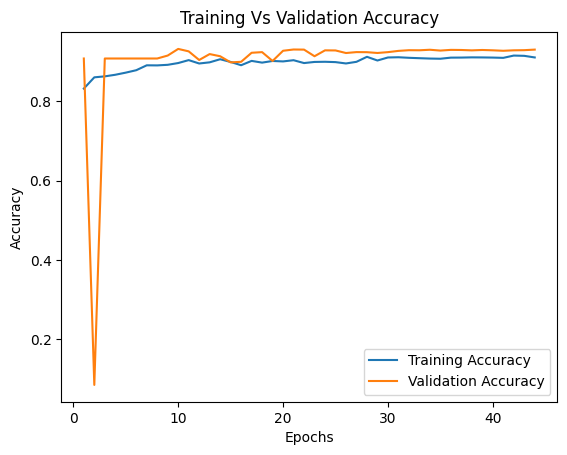

In [ ]:
# Assuming 'history' is the variable storing the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']  # Get accuracy from history
val_accuracy = history.history['val_accuracy']  # Get validation accuracy from history
epochs = range(1, len(loss) + 1)

plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.title("Training Vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('accuracy_plot.png',dpi=300)
plt.show()

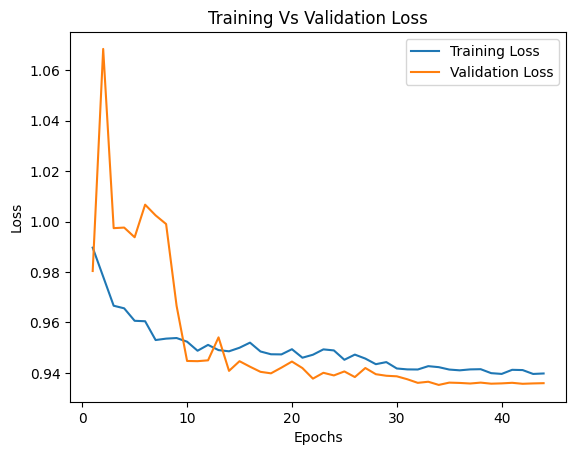

In [ ]:
# Assuming 'history' is the variable storing the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# ... (previous code for loading and training the model)

# Make predictions on the test data
y_pred = pspnet_model.predict(test_images)

# Convert predictions and ground truth to class labels
y_pred_argmax = np.argmax(y_pred, axis=3)  # Assuming y_pred has shape (num_samples, height, width, num_classes)
y_test_argmax = np.argmax(test_masks, axis=3)  # Assuming test_masks has shape (num_samples, height, width, num_classes)

# Reshape for use with sklearn metrics
y_pred_argmax_flattened = y_pred_argmax.flatten()
y_test_argmax_flattened = y_test_argmax.flatten()

# Calculate and print the metrics
accuracy = accuracy_score(y_test_argmax_flattened, y_pred_argmax_flattened)
precision = precision_score(y_test_argmax_flattened, y_pred_argmax_flattened, average='weighted')
recall = recall_score(y_test_argmax_flattened, y_pred_argmax_flattened, average='weighted')
f1 = f1_score(y_test_argmax_flattened, y_pred_argmax_flattened, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ... (rest of the code for plotting, etc.)

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 943ms/step
Accuracy: 0.9302
Precision: 0.9284
Recall: 0.9302
F1 Score: 0.9290


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
